In [1]:
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.cloud import storage
from io import StringIO
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
client = storage.Client()
bucket = client.get_bucket('bucket_l2_snapshot')

In [3]:
blob = bucket.blob('l2_snapshot_100ms.csv')
bt = blob.download_as_string()
s = str(bt, 'utf-8')
s = StringIO(s)

In [4]:
df = pd.read_csv(s, index_col=0, infer_datetime_format=True)

In [5]:
df.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,aq1,aq2,aq3,aq4,aq5,aq6,aq7,aq8,aq9,aq10
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-12 00:00:00.000,8721.53,8720.59,8719.55,8719.50,8719.0,8718.02,8717.87,8717.85,8717.56,8716.06,...,5.802204,2.859,0.12189,0.142575,0.002692,0.46,0.038468,0.200000,0.001890,1.00000
2019-11-12 00:00:00.100,8721.53,8720.59,8719.56,8719.55,8719.0,8718.02,8717.87,8717.85,8717.56,8716.06,...,5.802204,2.859,0.12189,0.142575,0.002692,0.46,0.038468,0.200000,0.001890,1.00000
2019-11-12 00:00:00.200,8721.53,8720.59,8719.61,8719.56,8719.0,8718.02,8717.87,8717.85,8716.06,8716.00,...,5.802204,2.859,0.12189,0.142575,0.002692,0.46,0.038468,0.200000,1.086016,0.00189
2019-11-12 00:00:00.300,8721.53,8720.59,8719.61,8719.56,8719.0,8718.02,8718.00,8717.87,8717.85,8716.60,...,7.802204,2.859,0.12189,0.142575,0.002692,0.46,0.038468,0.200000,1.086016,0.00189
2019-11-12 00:00:00.400,8721.53,8720.59,8719.61,8719.56,8719.0,8718.99,8718.02,8718.00,8717.87,8717.85,...,7.802204,2.859,0.12189,0.142575,0.002692,0.46,0.200000,0.038468,1.086016,0.00189


In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
def concat_data(base_path, features):
    """Concatenate all the files in basepath keeping only the
    columns specified by features.
    """
    l2_snapshot = pd.DataFrame()
    for i, x in enumerate(tqdm(sorted(os.listdir(base_path)))):
        if base_path is None:
            path = x
        else:
            path = base_path + x
        df_hour = pd.read_parquet(path, columns=features)
        l2_snapshot = pd.concat([l2_snapshot, df_hour.dropna()])
        
    return l2_snapshot

def extend_matrix(A, n):
    """Extend a matrix A by duplicating rows as specified by the list n."""
    n = n[1:]  # Do not duplicate rows for the first day
    A = A[:-1]  # Do not duplicate the last day's row
    A = np.repeat(A, repeats=n, axis=0)
    return A

def normalise_data_per_day(df):
    df_mean = df.resample('D').mean()
    df_var = df.resample('D').var()
    
    timestamps_per_day = np.unique(df.index.date, return_counts=True)[1]
    mean_array = extend_matrix(df_mean.to_numpy(), timestamps_per_day)
    var_array = extend_matrix(df_var.to_numpy(), timestamps_per_day)
    
    # Drop the rows of the first day
    df = df[df.index.date != df.index[0].date()]
    
    df = (df - mean_array) / np.sqrt(var_array)

    return df

def balance_classes(y):
    unique = np.unique(y, return_counts=True)

    # Take smallest number as class size
    class_size = np.min(unique[1])
    class_size_index = np.argmin(unique[1])
    timestamps = np.array([], dtype=int)
    for i, category in enumerate(unique[0]):
        if i == class_size_index:
            continue
        index = np.argwhere(y==category)
        index = index.reshape(len(index))
        random_timestamps = np.random.choice(index, (unique[1][i] - class_size), replace=False)
        timestamps = np.concatenate((timestamps, random_timestamps), axis=None)
        
    return timestamps

def generate_y(df_snapshot, T=100, D=40, best_ask='a1', best_bid='b1', k=20, alpha=10e-5):
    """Return X, y from the snapshot dataframe and the best ask/bid columns."""
    df = pd.DataFrame()
    df['mid_price'] = (df_snapshot[best_ask].to_numpy()+df_snapshot[best_bid].to_numpy())/2

    # Create columns delayed by -k to k-1
    for i in range(-k, k):
        df[i] = df['mid_price'].shift(periods=i)

    # Drop first k-1 rows and last k rows
    df.drop(range(0,20), axis=0, inplace=True)
    df.drop(range(len(df_snapshot)-20,len(df_snapshot)), axis=0, inplace=True)
    
    # Compute mean of previous k and next k
    df['m_b'] = df[range(0,20)].mean(axis=1)
    df['m_a'] = df[range(-20,0)].mean(axis=1)
    
    # Compute label of increasing or decreasing
    y_increase = np.where(df['m_b'] > df['m_a'] * (1+alpha), 1, 0)
    y_decrease = np.where(df['m_b'] < df['m_a'] * (1-alpha), -1, 0)
    y = y_increase + y_decrease

    # 100 most recent limit orders used so ignore first 100 timesteps
    y = y[T:]
    y += 1

    return y

def generate_preX(df_snapshot):
    # First and last 20 can't create labels for as previous and next k=20 needed
    preX = df_snapshot.to_numpy()[20:-20]

    return preX

def generate_X(preX, T=100, D=40):
    # For each timestep create matrix of 100 most recent limit orders
    X = np.array([preX[t:t+T] for t in range(len(preX)-T)], dtype='float32')
        
    return X

In [8]:
l2_norm = normalise_data_per_day(df)

In [9]:
l2_norm.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,aq1,aq2,aq3,aq4,aq5,aq6,aq7,aq8,aq9,aq10
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-13 00:00:00.000,2.069669,2.066221,2.049359,2.032164,2.045755,2.056132,2.062144,2.072841,2.064472,2.076723,...,-0.630327,-0.585376,-0.603213,-0.584939,-0.568453,-0.547841,-0.503235,-0.459792,-0.545609,-0.581027
2019-11-13 00:00:00.100,2.096553,2.099017,2.099095,2.093216,2.076695,2.060169,2.073992,2.084426,2.090621,2.101545,...,-0.630484,-0.585376,-0.603213,-0.584939,-0.568453,-0.547841,-0.559809,-0.556070,-0.552547,-0.576830
2019-11-13 00:00:00.200,2.096553,2.099017,2.099095,2.093216,2.076695,2.060169,2.073992,2.084426,2.090621,2.101545,...,-0.630484,-0.585376,-0.603213,-0.584939,-0.568453,-0.547841,-0.559809,-0.556070,-0.552547,-0.576830
2019-11-13 00:00:00.300,2.096553,2.085576,2.096676,2.062824,2.046024,2.059900,2.070222,2.076344,2.087117,2.078882,...,-0.630484,-0.585376,-0.603213,-0.584939,-0.568453,-0.547841,-0.559809,-0.556070,-0.552547,-0.576830
2019-11-13 00:00:00.400,2.096553,2.085576,2.096676,2.062824,2.046024,2.059900,2.070222,2.076344,2.064472,2.076723,...,-0.630484,-0.585376,-0.603213,-0.584939,-0.568453,-0.547841,-0.559809,-0.556070,-0.552547,-0.576830


In [10]:
T = 100
D = 40
y = generate_y(l2_norm, T=T, D=D, best_ask='a1', best_bid = 'b1', alpha=0.002)
preX = generate_preX(l2_norm)
print("preX Shape: ", preX.shape)
X = generate_X(preX)
print("X shape, y shape: ", X.shape, y.shape)
print("Unique y's: ", np.unique(y))

del preX
gc.collect()

# First and last 20 are removed to create labels and then last 100 as previous 100 is required for input matrix
X_index = l2_norm[20:-120].index

# Number of data points for the last day
num_test = np.unique(X_index.day, return_counts=True)[1][-1]

# Split the data into the first seven days and the last day
X_train_val = X[:-num_test]
y_train_val = y[:-num_test]
X_test = X[-num_test:]
y_test = y[-num_test:]

preX Shape:  (4220032, 40)
X shape, y shape:  (4219932, 100, 40) (4219932,)
Unique y's:  [0 1 2]


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from tcn import TCN, tcn_full_summary

In [12]:
from tensorflow import keras

In [22]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    i = Input(batch_shape=(None, 100, 40))
    o = TCN(return_sequences=False, use_skip_connections=True, dropout_rate=0.2)(i)
    o = Dense(3, activation='softmax')(o)
    m = Model(inputs=[i], outputs=[o])
    opt = keras.optimizers.Adam(learning_rate=0.001)
    m.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [23]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train_val), y_train_val)
d_class_weights = dict(enumerate(class_weights))

In [24]:
EPOCHS = 1000
model_filename = "model_resnet_walkforward_tcn.h5"
hist_filename = "hist_model_walkforward_tcn.csv"
early_stop = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=4)
model_save_checkpoint = keras.callbacks.ModelCheckpoint(
                            filepath= model_filename,
                            save_best_only=True,
                            monitor='val_loss',
                            verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=2,
                verbose=1,
                min_lr=0.0001)
callbacks = [reduce_lr, model_save_checkpoint, early_stop]
history = m.fit(
            X_train_val, y_train_val,
            epochs=EPOCHS,
            batch_size=128,
            callbacks=callbacks,
            class_weight = d_class_weights,
            validation_data = (X_test, y_test),
)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3754532 samples, validate on 465400 samples
Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 28 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 28 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
3754240/3754532 [============================>.] - ETA: 0s - loss: 0.7837 - accuracy: 0.6785
Epoch 00001: val_loss improved from inf to 0.64774, saving model to model_resnet_walkforward_tcn.h5
3754532/3754532 [==============================] - 506s 135us/sample - loss: 0.7837 - accuracy: 0.6785 - val_loss: 0.6477 - val_accuracy: 0.7247
Epoch 2/1000
3754496/3754532 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7326
Epoch 00002: val_loss improved from 0.64774 to 0.63731, saving model to model_resnet_walkforward_tcn.h5
3754532/3754532 [===============

In [25]:
y_pred = m.predict(X_test).argmax(axis=1)

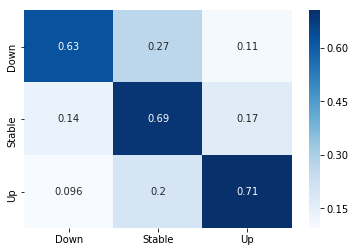

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax=sns.heatmap(cm, annot=True, xticklabels=['Down','Stable','Up'], yticklabels=['Down','Stable','Up'], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.savefig('image')

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.42      0.63      0.50     61142
          1       0.90      0.69      0.78    350499
          2       0.36      0.71      0.48     53759

avg / total       0.77      0.69      0.71    465400



In [19]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])